# Introduction

Author : ANAS RASHIDI


## Dataset Description
The dataset of images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou.

## Business Problem
Pneumonia is an infection that inflames the air sacs in one or both lungs. It kills more children younger than 5 years old each year than any other infectious disease, such as HIV infection, malaria, or tuberculosis. Diagnosis is often based on symptoms and physical examination. Chest X-rays may help confirm the diagnosis.

The most competent person to read the x-ray result is a doctor with their specialty in radiology. However, the x-ray result should be discovered in the shortest time, especially for emergency cases. In case there were no experts to read the x-ray result at a certain time the emergency come in, a computerized model to detect the pneumonia will help the treatment process of the emergency patient quickly.

## Objective
Create a deep learning model to detect the infection on lungs (pneumonia) with reliable accuracy value.

# Import Library

In [ ]:
# for data loading
from google.colab import drive
import pathlib

# for common use
import numpy as np
np.random.seed(42)
import pandas as pd
import random

# for data preprocessing and modelling
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

# for isualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [ ]:
# Checking for GPU/CPU usage
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("You're currently using CPU")

print(tf.__version__)

Default GPU Device:/device:GPU:0
2.6.0


# Data Loading

In [2]:
# Load dataset from Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Drive path to the dataset
train_folder='/content/drive/MyDrive/PNEUNOMIA/chest_xray/chest_xray/train'
validation_folder='/content/drive/MyDrive/PNEUNOMIA/chest_xray/chest_xray/val'
test_folder='/content/drive/MyDrive/PNEUNOMIA/chest_xray/chest_xray/test'

The dataset is already splitted into train data, validation data, and test data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exploration Data Analysis

In [ ]:
# Define the path of datasets
train_dir = pathlib.Path(train_folder)
val_dir = pathlib.Path(validation_folder)
test_dir = pathlib.Path(test_folder)

# Create list of each class/label in train_data
train_normal = list(train_dir.glob('NORMAL/*'))
train_pneumonia = list(train_dir.glob('PNEUMONIA/*'))

# Create list of each class/label in validation_data
val_normal = list(val_dir.glob('NORMAL/*'))
val_pneumonia = list(val_dir.glob('PNEUMONIA/*'))

# Create list of each class/label in test_data
test_normal = list(test_dir.glob('NORMAL/*'))
test_pneumonia = list(test_dir.glob('PNEUMONIA/*'))

In [ ]:
# Merge the list of each class in train_data
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

# Create dataframe of train_data
df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

# Merge the list of each class in validation_data
val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

# Create dataframe of validation_data
df_val = pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), columns = ['class'])
df_val['image'] = [x for x in val_list]

# Merge the list of each class in test_data
test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

# Create dataframe of test_data
df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

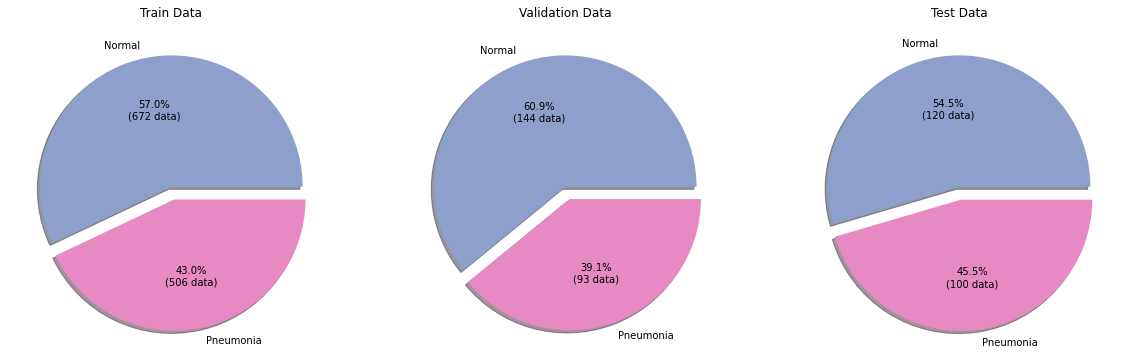

In [ ]:
# Function to show the exact data in pie charts
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} data)".format(pct, absolute)

# Variable used for pie charts
colors = sns.color_palette('Set2')[2:5]
labels = ['Normal', 'Pneumonia']
explode=[0,0.1]

# Show pie charts
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('Train Data')
plt.pie(df_train['class'].value_counts(), autopct=lambda pct: func(pct, df_train['class'].value_counts()),
        colors=colors, labels=labels, shadow=True, explode=explode)

plt.subplot(1,3,2)
plt.title('Validation Data')
plt.pie(df_val['class'].value_counts(), autopct=lambda pct: func(pct, df_val['class'].value_counts()),
        colors=colors, labels=labels, shadow=True, explode=explode)

plt.subplot(1,3,3)
plt.title('Test Data')
plt.pie(df_test['class'].value_counts(), autopct=lambda pct: func(pct, df_test['class'].value_counts()),
        colors=colors, labels=labels, shadow=True, explode=explode)
plt.show()

The datasets seem to have balanced data between the Normal x-ray and Pneumonia x-ray



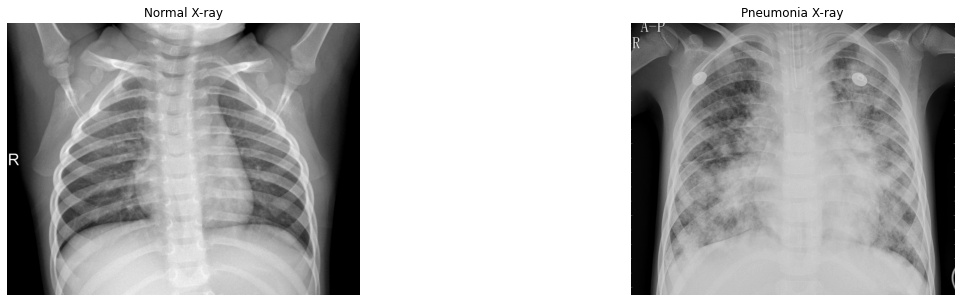

Normal X-ray Image Size: (1291, 1674)                                       Pneumonia X-ray Image Size: (1184, 1408)


In [ ]:
# Show the images (dataset sample) from each class
random_image_normal = random.sample(train_normal,1)
random_image_pn = random.sample(train_pneumonia,1)
img_norm = mpimg.imread(random_image_normal[0])
img_pn = mpimg.imread(random_image_pn[0])

# Show the images (dataset sample) from normal data train
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(img_norm, cmap='gray')
plt.axis("off")
plt.title("Normal X-ray")

# Show the images (dataset sample) from pneumonia data train
plt.subplot(1,2,2)
plt.imshow(img_pn, cmap='gray')
plt.axis("off")
plt.title("Pneumonia X-ray")
plt.show()

print('Normal X-ray Image Size:', img_norm.shape, '                                      Pneumonia X-ray Image Size:', img_pn.shape)

The pictures above are the sample image from dataset. Each file has different image size. Therefore, we will standardize the image size in preprocessing data.

# Data Preprocessing

## Dataset Loading

In [ ]:
# Set the image size and batch size
IMG_WIDTH=224
IMG_HEIGHT=224
batch_size=32

In [ ]:
# Loading train dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    shuffle=True,
    batch_size=batch_size,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
    )

Found 1178 files belonging to 2 classes.


In [ ]:
# Loading validation dataset
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_folder,
    shuffle=True,
    batch_size=batch_size,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
    )

Found 237 files belonging to 2 classes.


In [ ]:
# Loading test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder,
    shuffle=True,
    batch_size=batch_size,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
    )

Found 220 files belonging to 2 classes.


In [ ]:
# Show the label / class name
class_names = train_dataset.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [ ]:
# Manually iterate over the dataset and retrieve batches of images
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


## Configure Dataset
Use buffered prefetching so we can yield data from disk without having I/O become blocking. Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
# Optimasi untuk menghindari bottleneck
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

## Standardize the Data

The RGB channel values are in the [0, 255] range.
In neural network, we should standardize values to be in the [0, 1] range by using a Rescaling layer.

In [ ]:
# Defining the layer for rescaling data
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
# Apply rescaling into the dataset
normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Modelling
In this project, we will try to create 3 models:
*   Model 1 = Basic CNN Model
*   Model 2 = Transfer Learning using MobilenetV2
*   Model 3 = Fine Tuning using MobilenetV2





## Model 1 - Convolution Neural Network

In [ ]:
# Create the model
model1 = Sequential()
model1.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (IMG_HEIGHT,IMG_WIDTH,3)))
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model1.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model1.add(Flatten())
model1.add(Dense(units = 128 , activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units = 1 , activation = 'sigmoid'))

# Compile the model
model1.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

# Show the model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

In [ ]:
# Fit train the model
keras.backend.clear_session()
history1 = model1.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs = 30)

Epoch 1/30
37/37 [==============================] - 31s 841ms/step - loss: 1.1269 - accuracy: 0.7411 - val_loss: 0.4199 - val_accuracy: 0.8228
Epoch 2/30
37/37 [==============================] - 1s 31ms/step - loss: 0.3733 - accuracy: 0.8413 - val_loss: 0.3463 - val_accuracy: 0.8776
Epoch 3/30
37/37 [==============================] - 1s 31ms/step - loss: 0.2726 - accuracy: 0.8922 - val_loss: 0.2311 - val_accuracy: 0.9072
Epoch 4/30
37/37 [==============================] - 1s 30ms/step - loss: 0.1442 - accuracy: 0.9457 - val_loss: 0.1260 - val_accuracy: 0.9536
Epoch 5/30
37/37 [==============================] - 1s 30ms/step - loss: 0.1025 - accuracy: 0.9618 - val_loss: 0.1134 - val_accuracy: 0.9620
Epoch 6/30
37/37 [==============================] - 1s 30ms/step - loss: 0.0788 - accuracy: 0.9711 - val_loss: 0.0976 - val_accuracy: 0.9578
Epoch 7/30
37/37 [==============================] - 1s 30ms/step - loss: 0.0510 - accuracy: 0.9839 - val_loss: 0.1598 - val_accuracy: 0.9536
Epoch 8/30


In [ ]:
# Function to plot the result
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(history.history['loss']))

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylim(0,1)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylim(0,1)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()

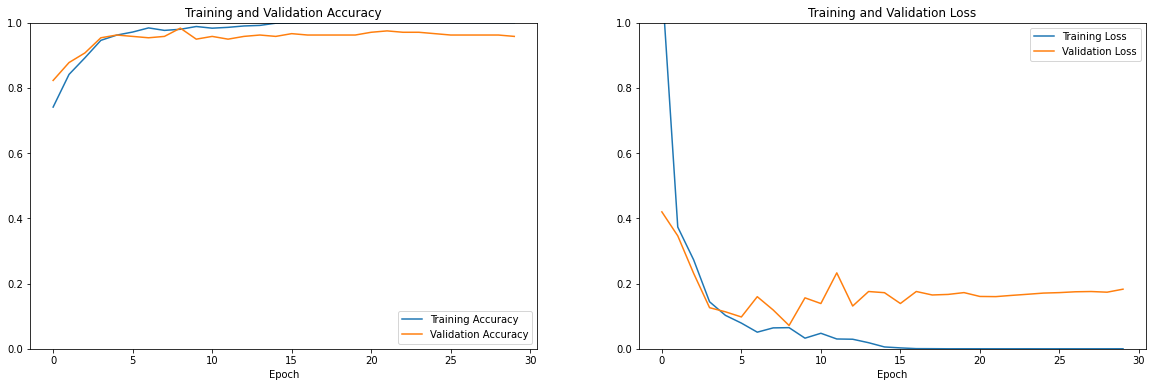

In [ ]:
# Plot the training result of Model 1
plot_result(history1)

In [ ]:
# Evaluate on test dataset
loss1, accuracy1 = model1.evaluate(test_dataset)
print('Test accuracy :', accuracy1)

7/7 [==============================] - 23s 42ms/step - loss: 0.2124 - accuracy: 0.9545
Test accuracy : 0.9545454382896423


## Model 2 - Transfer Learning using MobileNetV2

In [ ]:
# Define the pre-trained model into base_model
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(IMG_HEIGHT,IMG_WIDTH,3),
                                                            include_top=False,
                                                            weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Freeze the convolutional base
base_model.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


This feature extractor converts each image into a 7x7x1280 block of features. Let's take a look at the architecture of the base model

In [ ]:
# Show summary of base model
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

We use the preprocessing method included with the model to rescale the pixel values.

In [ ]:
# Define the preprocess input to be used in the model
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Create the model
inputs = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)

# Head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)

#Final Layer (Output)
output = layers.Dense(1, activation='sigmoid')(x)

model2 = keras.Model(inputs=[inputs], outputs=output)
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

In [ ]:
# Compile the model
model2.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [ ]:
# Fit train the model
keras.backend.clear_session()
history2 = model2.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs = 30)

Epoch 1/30
37/37 [==============================] - 5s 69ms/step - loss: 0.2800 - accuracy: 0.8727 - val_loss: 0.1513 - val_accuracy: 0.9620
Epoch 2/30
37/37 [==============================] - 1s 38ms/step - loss: 0.1464 - accuracy: 0.9457 - val_loss: 0.1425 - val_accuracy: 0.9536
Epoch 3/30
37/37 [==============================] - 1s 38ms/step - loss: 0.1261 - accuracy: 0.9440 - val_loss: 0.0759 - val_accuracy: 0.9747
Epoch 4/30
37/37 [==============================] - 1s 37ms/step - loss: 0.0831 - accuracy: 0.9728 - val_loss: 0.0649 - val_accuracy: 0.9789
Epoch 5/30
37/37 [==============================] - 1s 38ms/step - loss: 0.0683 - accuracy: 0.9788 - val_loss: 0.0617 - val_accuracy: 0.9789
Epoch 6/30
37/37 [==============================] - 1s 37ms/step - loss: 0.0599 - accuracy: 0.9805 - val_loss: 0.0647 - val_accuracy: 0.9789
Epoch 7/30
37/37 [==============================] - 1s 37ms/step - loss: 0.0505 - accuracy: 0.9779 - val_loss: 0.0684 - val_accuracy: 0.9662
Epoch 8/30
37

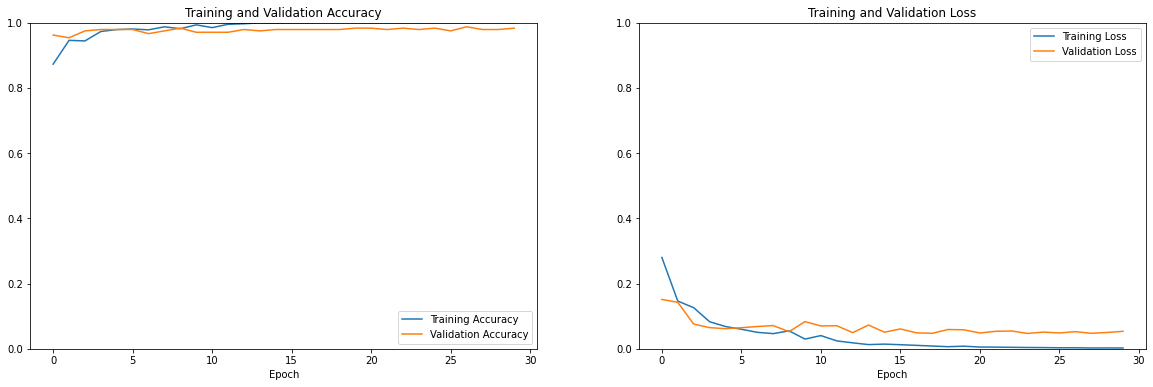

In [ ]:
# Show training result of the model 2
plot_result(history2)

In [ ]:
# Evaluate model 2 on test dataset
loss2, accuracy2 = model2.evaluate(test_dataset)
print('Test accuracy :', accuracy2)

7/7 [==============================] - 0s 51ms/step - loss: 0.0564 - accuracy: 0.9818
Test accuracy : 0.9818181991577148


## Model 3 - Fine Tuning
In Model 2 we were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

In [ ]:
# Unfreeze the convolutional base
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
# Create model
inputs = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH, 3))
x = preprocess_input(inputs)
x = base_model(x)

# Head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)

#Final Layer (Output)
output = layers.Dense(1, activation='sigmoid')(x)

model3 = keras.Model(inputs=[inputs], outputs=output)
model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

In [ ]:
# Compile the model
model3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

In this model, we use much lower learning rate so the model won't be quickly overfit. Then we continue / resume the training model from the previous training model

In [ ]:
initial_epochs = 30
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

keras.backend.clear_session()
history3 = model3.fit(train_dataset,
                      epochs = total_epochs,
                      initial_epoch = history2.epoch[-1], # continue training from the previous training model
                      validation_data=validation_dataset)

Epoch 30/60
37/37 [==============================] - 2s 52ms/step - loss: 2.9737e-04 - accuracy: 1.0000 - val_loss: 0.5506 - val_accuracy: 0.7975
Epoch 31/60
37/37 [==============================] - 2s 45ms/step - loss: 2.8236e-04 - accuracy: 1.0000 - val_loss: 0.4881 - val_accuracy: 0.8186
Epoch 32/60
37/37 [==============================] - 2s 45ms/step - loss: 2.4151e-04 - accuracy: 1.0000 - val_loss: 0.4380 - val_accuracy: 0.8354
Epoch 33/60
37/37 [==============================] - 2s 45ms/step - loss: 2.2340e-04 - accuracy: 1.0000 - val_loss: 0.3903 - val_accuracy: 0.8523
Epoch 34/60
37/37 [==============================] - 2s 45ms/step - loss: 1.9124e-04 - accuracy: 1.0000 - val_loss: 0.3476 - val_accuracy: 0.8608
Epoch 35/60
37/37 [==============================] - 2s 45ms/step - loss: 1.5870e-04 - accuracy: 1.0000 - val_loss: 0.3095 - val_accuracy: 0.8734
Epoch 36/60
37/37 [==============================] - 2s 45ms/step - loss: 1.4677e-04 - accuracy: 1.0000 - val_loss: 0.2779 -

In [ ]:
acc3 = history3.history['accuracy'] + history2.history['accuracy']
val_acc3 = history3.history['val_accuracy'] + history2.history['val_accuracy']

loss_3 = history3.history['loss'] + history2.history['loss']
val_loss3 = history3.history['val_loss'] + history2.history['loss']

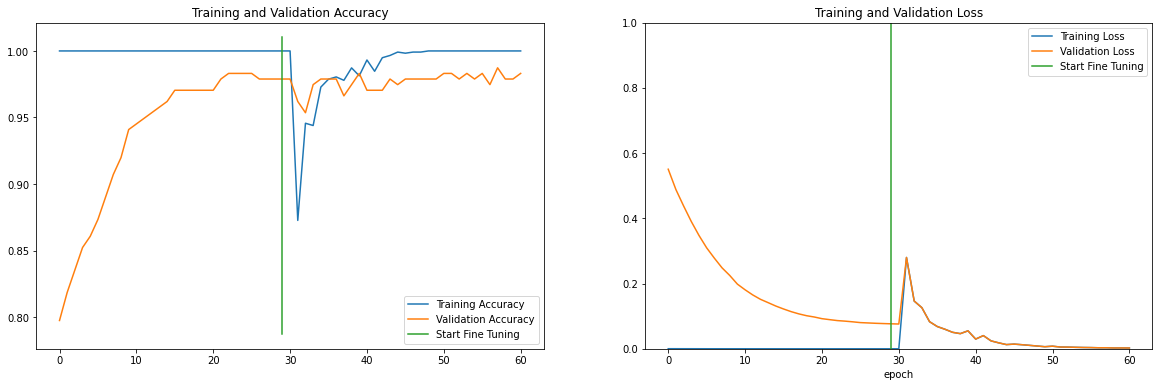

In [ ]:
# Plot the training result
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(acc3, label='Training Accuracy')
plt.plot(val_acc3, label='Validation Accuracy')
#plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_3, label='Training Loss')
plt.plot(val_loss3, label='Validation Loss')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

When the fine tuning is starting, the loss and accuracy are a bit overfit and unstable. But as the epoch continues, the result become much better.

In [ ]:
loss3, accuracy3 = model3.evaluate(test_dataset)
print('Test accuracy :', accuracy3)

7/7 [==============================] - 0s 29ms/step - loss: 0.0514 - accuracy: 0.9818
Test accuracy : 0.9818181991577148


# Model Evaluation

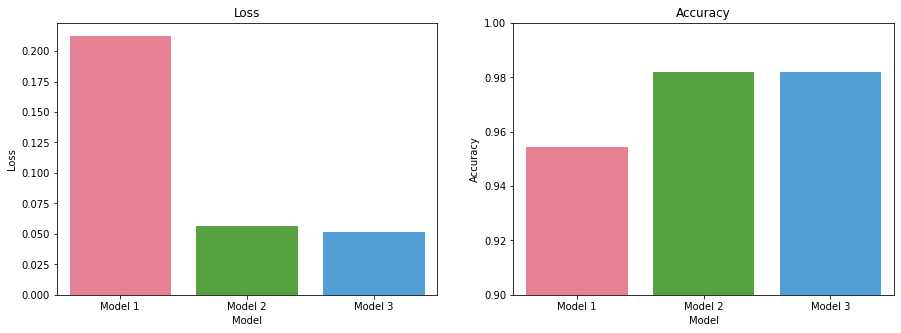

In [ ]:
import pandas as pd
import seaborn as sns
eval = pd.DataFrame({'Model' : ["Model 1", "Model 2", "Model 3"],
                      'Loss' : [loss1, loss2, loss3],
                      'Accuracy' : [accuracy1, accuracy2, accuracy3]})

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Loss')
sns.barplot(data=eval, x='Model', y='Loss', palette='husl')
plt.subplot(1,2,2)
plt.title('Accuracy')
sns.barplot(data=eval, x='Model', y='Accuracy', palette='husl')
plt.ylim(0.9,1)
plt.show()

After we evaluate all the model into the test dataset, as the above picture shows, we have Model 3 as our best model. However, Model 3 should only be attempted after we have trained the top-level classifier with the pre-trained model set to non-trainable (after Model 2 is trained).

Model 2 and Model 3 seem to have a similar accuracy, but Model 3 got lower loss than Model 2.

# Model Inference
Now let's try to predict some sample images from data test with Model 3 as the best model.

Predictions:
 [0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 1]
Labels:
 [0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 1]


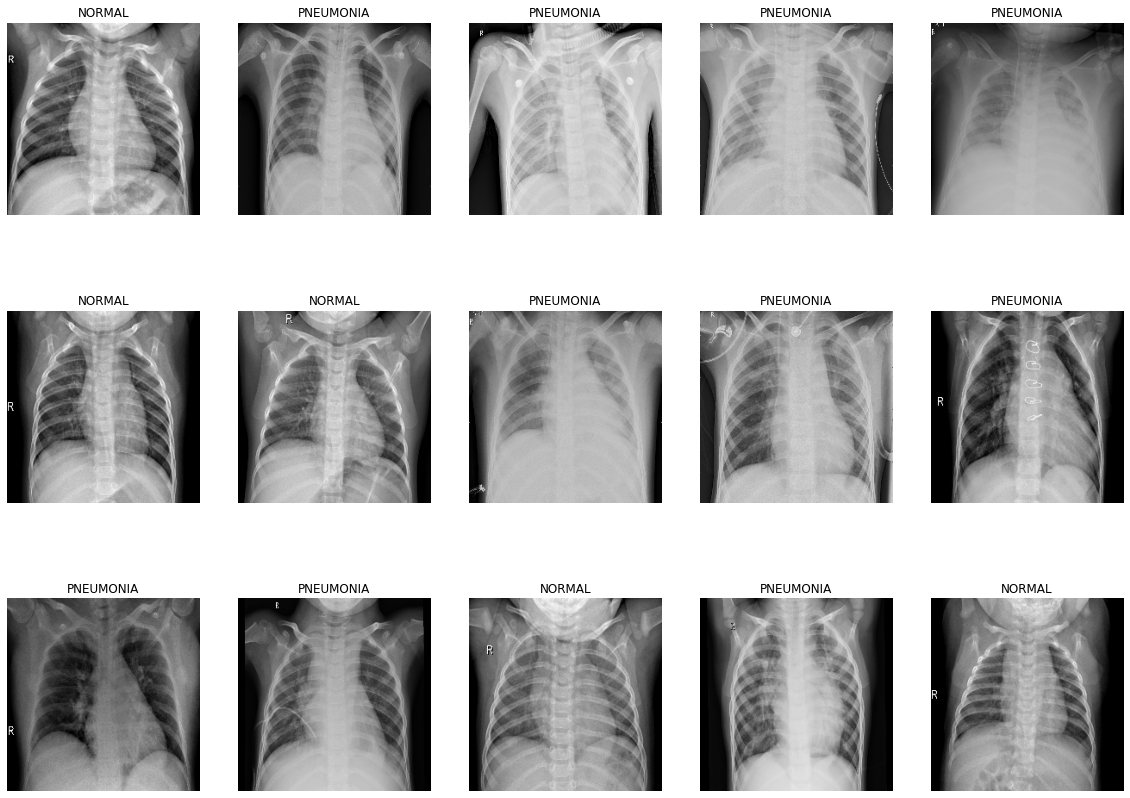

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model3.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.6, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 15))
for i in range(15):
  ax = plt.subplot(3, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Conclusion

1. The dataset contains x-ray image files of lungs in normal condition and lungs with pneumonia. It's already grouped into train data, validation data, and test data
2. While loading the dataset, we resize the image and we pre-process them by using the buffered prefetch and rescaling.
3. For first model (Model 1) training, we created the basic convolution neural network model. For the second model (Model 2), we used the pre-trained model (MobileNetV2) to extract the features without training the whole layers of convolutional base model. Model 2 reached much better accuracy and loss.
4. Then to improve the model further, we create the Model 3 (fine tuning from the pre-trained model). It gets overfit at first, but getting much better result after several epochs (even better than Model 2).
5. After we evaluate the models into the test dataset,
    - Model 1 reached the lowest accuracy(95%) and highest loss(21%)
    - Model 2 reached the highest accuracy(98%) and second highest loss(5.6%)
    - Model 3 reached the highest accuracy(98%) and the lowest loss(5.1%)
6. Therefore, we chose Model 3 as the best model to detect the pneumonia in x-ray images to help any medical institution in treating their emergency patients, especially in this pandemic condition where mostly all medical personnel are in their hardship.

